# ENGHACK2021: Introduction to TensorFlow/Keras, By Andrew Shao

> CIFAR-10 Tutorial, the full Deep Learning Pipeline


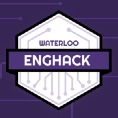




# 1) Understanding the Problem
- In this tutorial, our goal is to classify images into 10 classes using Deep Learning
- This system could be used for visual recognition and surveillance systems.

# 2) Find Data
- A simple dataset for this task is CIFAR10

Properties of the Dataset:
- 32x32 RGB images
- 60000 images, with 10 classes
- 6000 images per class, equal class distribution

Import the Dependencies(tensorFlow + Keras, numpy, pandas, etc.)

In [1]:
import tensorflow as tf
import tensorflow.keras as keras # TensorFlow + Keras
import numpy as np
import pandas as pd # Data science modules
import tensorflow_datasets as tfds # Load datasets
# Visualization Imports
import matplotlib.pyplot as plt # Image Visualization

In [2]:
datasets = tfds.load('cifar10') # Download the Dataset(This may take a few minutes)

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteD5O0QF/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteD5O0QF/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [3]:
# Look inside the Datasets
# NOTE: For convenience, TensorFlow Datasets already gives a tf.data.Dataset for you, which simplifies the data pipeline
datasets

{'test': <PrefetchDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>,
 'train': <PrefetchDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>}

# 3) Process Data
- Perform an Exploratory Data Analysis(EDA)
- Preprocess and create a basic data pipeline

In [4]:
# Classes to IDX
ALL_CLASSES = [
  'airplane',										
  'automobile',
  'bird',										
  'cat',										
  'deer',										
  'dog',										
  'frog',									
  'horse',										
  'ship',										
  'truck'
]
# Generate Class2Idx
CLASS2IDX = {ALL_CLASSES[idx]: idx for idx in range(len(ALL_CLASSES))} # dictionary comprehension
IDX2CLASS = {idx: ALL_CLASSES[idx] for idx in range(len(ALL_CLASSES))}
NUM_CLASSES = len(ALL_CLASSES)

In [5]:
# Grab Train and Test Dataset 
train_dataset = datasets['train'] # 50000 images
test_dataset = datasets['test'] # 10000 images

test_len = len(test_dataset) 

val_split = 0.1
val_len = int(len(train_dataset) * val_split) # 5000 Samples
train_len = len(train_dataset) - val_len # 45000 Samples


In [6]:
# TO AVOID DATA LEAKAGE, CREATE A VALIDATION SET(1 / 10th of the dataset):
train_dataset = train_dataset.shuffle(5000) # Shuffle the dataset first, for randomness, with shuffle buffer 5000
train_split = train_dataset.take(train_len) # Grab the first 45000 samples
val_split = train_dataset.skip(val_len)

In [7]:
# Just rename the variables
train_dataset = train_split
val_dataset = val_split

Basic Visualization of Images(Exploratory Data Analysis)

Image Label: horse


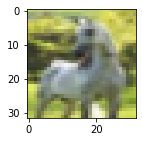

Image Label: deer


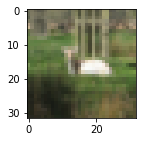

Image Label: ship


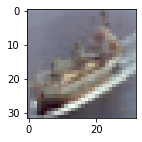

Image Label: cat


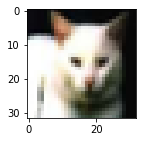

Image Label: horse


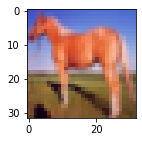

IMAGE SHAPE: (32, 32, 3)
ID Shape: ()
LABEL Shape: ()


In [8]:
for dictionary in train_dataset.take(5): # visualize 5 samples
  image = dictionary['image']
  id = dictionary['id']
  label = dictionary['label']

  print(f"Image Label: {IDX2CLASS[label.numpy().item()]}")
  plt.figure(figsize = (2, 2)) # Just set the images a little smaller, because they are very pixely and need to be zoomed out to see what's inside.
  plt.imshow(image.numpy()) # Eager Execution allows us to swap between TensorFlow and Numpy
  plt.show()
# Print Tensor Shapes
print(f"IMAGE SHAPE: {image.shape}")
print(f"ID Shape: {id.shape}")
print(f"LABEL Shape: {label.shape}")


Use a few tf.data functions to transform the dataset to a clean (x, y) batched dataset

In [9]:
class DataConfig:
  # Config Variables for Datasets
  batch_size = 32 # How many images to process in one batch(Could be as large as you want for CIFAR10, but for larger datasets, you may be restricted by hardware)

In [10]:
def process_image(image):
  # Image PreProcessing
  image = tf.cast(image, tf.float32) / 255.0 # Turn images from 0 -> 255, to 0 -> 1.0
  return image


def dict_to_pair(dictionary):
  image = dictionary['image']
  id = dictionary['id']
  label = dictionary['label']
  return process_image(image), label 


def process_dataset(dataset, is_train = False):
  AUTO = tf.data.experimental.AUTOTUNE
  # Turn off Determinism for Speed Increases
  options = tf.data.Options()
  options.experimental_deterministic = False

  # Convert a Dictionary Based Dataset to (x, y) pairs.
  dataset = dataset.with_options(options) # Turn off determinism
  
  dataset = dataset.map(lambda dictionary: dict_to_pair(dictionary), num_parallel_calls = AUTO, deterministic = False) # Map the dataset to (x, y)
  # Shuffle the Dataset
  if is_train:
    dataset = dataset.shuffle(5000) # Buffer size 5000
  # Batch the Dataset
  dataset = dataset.batch(DataConfig.batch_size, drop_remainder = False)
  # Optimization Techniques
  dataset = dataset.prefetch(AUTO)
  return dataset

In [11]:
# Process all Datasets
train_dataset = process_dataset(train_dataset, is_train = True)
val_dataset = process_dataset(val_dataset, is_train = False)
test_dataset = process_dataset(test_dataset, is_train = False)

# 4) Define the Models
- We will be using 2 Models in this tutorial: a Convolutional Neural Network and a Multilayered Perceptron

1) Model #1: Multi Layered Perceptron


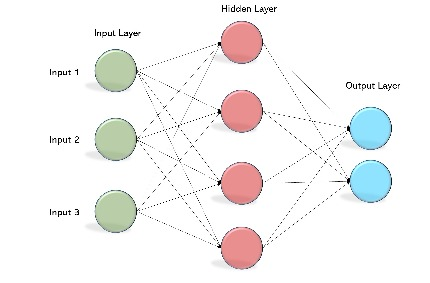

In [12]:
# Creating Custom Layers 
class MLP(keras.Model):
  def __init__(self):
    super().__init__() # Initialize keras.Model 
    self.num_classes = NUM_CLASSES
    self.MLP = keras.Sequential([
      keras.layers.Reshape((32 * 32 * 3, ), input_shape = (32, 32, 3)),
      keras.layers.Dense(1024, activation = 'relu'),
      keras.layers.Dense(1536, activation = 'relu'),
      keras.layers.Dense(self.num_classes)
    ])
  def call(self, x, training):
    # X: tensor(B, 32, 32, 3)
    return self.MLP(x, training = training)

In [13]:
class MLPTrainingConfig:
  num_epochs = 20

# basic training script 
def train_MLP(file_path):
  '''
  File_path: file_path to save the MLP
  '''
  # create a model
  model = MLP()
  # compile it
  model.compile(
      optimizer = 'adam',
      loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
      metrics = [
          keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')
      ]
  )
  # create model callback to save model
  callbacks = [
    keras.callbacks.ModelCheckpoint(file_path, monitor = 'val_accuracy', save_best_only = True, save_weights_only = True)
  ]
  model(tf.identity(np.zeros((1, 32, 32, 3))))
  # train the model
  model.fit(train_dataset, epochs = MLPTrainingConfig.num_epochs, callbacks = callbacks, validation_data=val_dataset)


This simple 3 layer model should be able to achieve around 45% accuracy in 1 minute(On GPU, on CPU it will take around 7 minutes)

In [ ]:
train_MLP('./mlp.h5') # Train the MLP

2) Model #2: Transfer Learned ResNet50
- Transfer Learning is the idea of using pretrained Convolutional Neural Network weights to accelerate training
- We will be using a simple CNN, pretrained on ImageNet, and we will finetune on CIFAR-10.

In [25]:
# BackBone Model
class ResNetBackBone(keras.layers.Layer):
  def __init__(self, freeze =False):
    super().__init__()
    self.freeze = freeze
    self.backbone = (include_top = False, input_shape = (32, 32, 3)) # Just the backbone
    # Freeze Backbone, to prevent overfitting 
    if self.freeze:
      self.backbone.trainable = False
  def __call__(self, x, training):
    return self.backbone(x, training = training) # (B, 1, 1, 2048) - Typically, images should be much larger.

# Model Head
class Head(keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.num_classes = NUM_CLASSES
    self.LinearHead = keras.Sequential([
        keras.layers.Reshape((2048, ), input_shape = (1, 1, 2048)),
        keras.layers.Dense(1024, activation = 'relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(self.num_classes)
    ])
  def __call__(self, x, training):
    # x: Tensor(B, 1, 1, 2048)
    return self.LinearHead(x, training = training) # (B, C)


# Full CNN Model
class TransferLearnedCNN(keras.Model):
  def __init__(self):
    super().__init__()
    self.backbone = ResNetBackBone()
    self.head = Head() # Load the Model 

  def call(self, x, training): # Note the "call" and not "__call__"(keras handles the Model Logic)
    features = self.backbone(x, training = training)
    return self.head(features, training = training)
    

In [26]:
class CNNTrainingConfig:
  num_epochs = 20
def train_CNN(file_path):
  model = TransferLearnedCNN()
  # compile the model
  model.compile(
      optimizer = 'adam',
      loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
      metrics = [
         keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')
      ]
  )
  # callbacks
  callbacks = [
    keras.callbacks.ModelCheckpoint(file_path, monitor = 'val_accuracy', save_best_only=True, save_weights_only=True)
  ]
  # Fit the Model 
  model.fit(train_dataset, epochs = CNNTrainingConfig.num_epochs, callbacks = callbacks, validation_data = val_dataset)

A ResNet50 is slower than a simple 3 Layer Perceptron, so expect training to take 1 minute 20 seconds per epoch on GPU and much longer on CPU(Convolutions are optimized on GPU to run fast).

In terms of performance, expect the model to perform much better than the MLP. It should converge in around 8-9 Epochs and begin **Overfitting** soon after(Too large capacity for too little data).

Performance Stats: 85% Validation Accuracy after 10 -15 epochs.




In [ ]:
train_CNN('./CNN.h5') # Train and Save the ResNet-50

Epoch 1/20
1407/1407 [==============================] - 74s 48ms/step - loss: 1.7107 - accuracy: 0.4397 - val_loss: 94.9885 - val_accuracy: 0.1659
Epoch 2/20
1407/1407 [==============================] - 72s 51ms/step - loss: 1.3919 - accuracy: 0.5436 - val_loss: 1.8444 - val_accuracy: 0.5163
Epoch 3/20
1407/1407 [==============================] - 67s 47ms/step - loss: 1.3451 - accuracy: 0.5621 - val_loss: 1.8018 - val_accuracy: 0.4786
Epoch 4/20
1407/1407 [==============================] - 67s 47ms/step - loss: 1.2039 - accuracy: 0.6046 - val_loss: 2.6429 - val_accuracy: 0.3438


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f1c329c17a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 5/20
1407/1407 [==============================] - 67s 47ms/step - loss: 1.2768 - accuracy: 0.5769 - val_loss: 1.2956 - val_accuracy: 0.5715
Epoch 6/20
1407/1407 [==============================] - 67s 47ms/step - loss: 1.0379 - accuracy: 0.6574 - val_loss: 1.1116 - val_accuracy: 0.6316
Epoch 7/20
1407/1407 [==============================] - 67s 47ms/step - loss: 1.1321 - accuracy: 0.6279 - val_loss: 0.9956 - val_accuracy: 0.6496
Epoch 8/20
1407/1407 [==============================] - 67s 47ms/step - loss: 1.0309 - accuracy: 0.6540 - val_loss: 1.0523 - val_accuracy: 0.6581
Epoch 9/20
1407/1407 [==============================] - 72s 51ms/step - loss: 0.7925 - accuracy: 0.7332 - val_loss: 0.9341 - val_accuracy: 0.7051
Epoch 10/20
1407/1407 [==============================] - 67s 47ms/step - loss: 0.7491 - accuracy: 0.7487 - val_loss: 0.8750 - val_accuracy: 0.7165
Epoch 11/20
1407/1407 [==============================] - 67s 47ms/step - loss: 0.6952 - accuracy: 0.7675 - val_loss: 1.0058

You can download your trained weights(MLP and CNN), in the colab storage, since we saved the models using SaveModelCallback. Loading the weights is as simple as the following(Load in CNN weights):


# 5) Test the model
- Make sure that the model hasn't overfit the validation set 
- Have a number for your research paper or the conference room.

In [ ]:
# Testing Script


# 6) Inference Loop and Deployment:
- Basic Model Loading Script
- Basic Image Loading and Preprocessing Script in Eager Mode
- Basic Inference Code(deployment)

# 7) Future Improvement and Maintenance:
Rules of Thumb for Better Performance:

**Data**: More Data, Better quality(32x32 -> 224x224), Data Augmentation

**Model**: Larger Models, Prevent Overfitting(Weight decay, dropout, etc.), specialized models, pretrained models + transfer learning.